The brow-zer places the projector in the eyebrow region and uses a tilted selective reflector.  We will build the curves for projector and reflector by starting at a central point and then building outwards by successive approximation.  Each step in approximation begins with a prior projector, reflector pair which produce a ray to the center of the eye.  It then takes a slight angular step from the projection point and builds a new reflector point on a surface which should generate a parallel ray creating a virtual image at far distance beyond the reflector.

In [1]:
import math
from memory import memset_zero

# a 2D point, interchangeable with a 2D relative vector
@value
struct Point2D(CollectionElement) :
    var x: Float64
    var y: Float64

    fn __moveinit__(inout self, owned existing: Self):
        self.x = existing.x
        self.y = existing.y

    fn __add__(self, other : Self) -> Point2D :
        return Point2D(self.x + other.x, self.y + other.y)

    fn __sub__(self, other : Self) -> Point2D :
        return Point2D(self.x - other.x, self.y - other.y)

    fn __mul__(self, scale : Float64) -> Point2D :
        return Point2D(self.x * scale, self.y * scale)

    fn __truediv__(self, scale : Float64) -> Point2D :
        return Point2D(self.x / scale, self.y / scale)

    fn dot(self, other : Point2D) -> Float64 :
        return self.x * other.x + self.y * other.y
    
    fn length(self) -> Float64 :
        return math.sqrt(self.x * self.x + self.y * self.y)

# a mirror position has a point and a tangent angle
@value
struct Mirror2D(CollectionElement) :
    var p : Point2D
    var tan : Float64

    fn __moveinit__(inout self, owned existing: Self):
        self.p = existing.p
        self.tan = existing.tan

# a pair returned from the step calculation
@value
struct PointMirrorPair(CollectionElement) :
    var p : Point2D
    var m : Mirror2D

    fn __moveinit__(inout self, owned existing: Self):
        self.p = existing.p
        self.m = existing.m

# anti-clockwise rotation
# ( cos(Ɵ)   -sin(Ɵ) )
# ( sin(Ɵ)   cos(Ɵ)  )
@value
struct Rotate2D :
    var cosTheta : Float64
    var sinTheta : Float64

    fn __init__(inout self, theta : Float64) :
        self.cosTheta = math.cos(theta)
        self.sinTheta = math.sin(theta)

    fn rot(self, pIn : Point2D) -> Point2D :
        return Point2D((pIn.x * self.cosTheta) - (pIn.y * self.sinTheta), (pIn.x * self.sinTheta) + (pIn.y * self.cosTheta))


In [2]:
struct Array[AT : CollectionElement, rows: Int]:
    var data : AnyPointer[AT]

    # Initialize zeroing all values
    fn __init__(inout self):
        self.data = AnyPointer[AT].alloc(rows)

    fn __getitem__(self, i: Int) -> AT:
        return self.data[i]

    fn __setitem__(self, i : Int, val: AT):
        self.data[i] = val

projs = Array[Point2D, 11]()

In [3]:
# mojo math does not seem to provide constants, so do this by hand
pi = 3.14159265358979323846

# the center of the eye is the origin for geometry
c = Point2D(0.0, 0.0)

# an initial mirror position on the horizontal axis is our starting point.
# we could choose a slightly below horizontal axis, should be the resting point for gaze.
# it will be the position with best resolution, compromises accumulate away from this
#
var m0 = Mirror2D (Point2D(60.0, 0.0), pi / 4)

# an initial projector point (pixel) is chosen at 45 degrees, arbitrary
# a real-world central pixel would consider the resting gaze and locating projector comfortably
#
var p0 = Point2D(38.7868, 21.2132)
#.70710678118
# create vectors to pixel from mirror and to eye center from mirror
var p_m = p0 - m0.p
var c_m = c - m0.p

# lengths for convenience
var r = p_m.length()
var R = c_m.length()

# theta is the half-angle between them - the angle from the normal at the mirror
theta = math.acos(p_m.dot(c_m) / (r*R)) / 2

# we should have r=30, and theta=pi/8
print (r, theta, pi / 8)

29.999995141332942 0.3926990816987242 0.39269908169872414


![geometry with eye.png](<attachment:geometry with eye.png>)
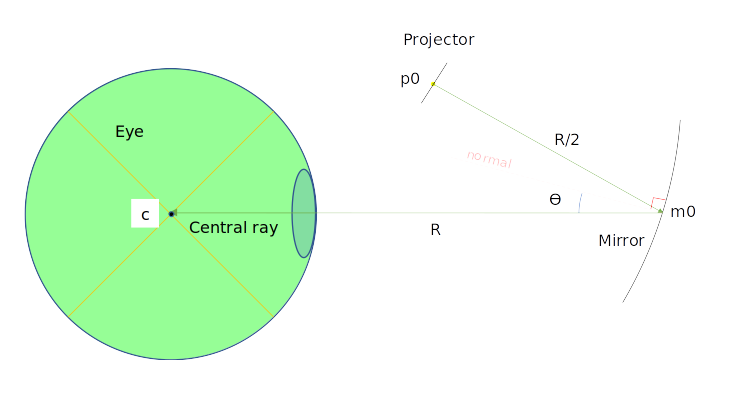

In [4]:
# a rotation for the mirror half angle
Mtheta = Rotate2D(theta) 

# project the mirror normal back to a point on parabola axis shared with p0
vR = Mtheta.rot(p_m) * (2 * math.cos(theta))

# the virtual center for the mirror is that axis point
vC = m0.p + vR

print("[", p_m.x, ", ", p_m.y, "], [", vR.x, ", ", vR.y, "]")

[ -21.213200000000001 ,  21.213200000000001 ], [ -51.213195141332939 ,  21.213200000000001 ]


![first ray.png](<attachment:first ray.png>)
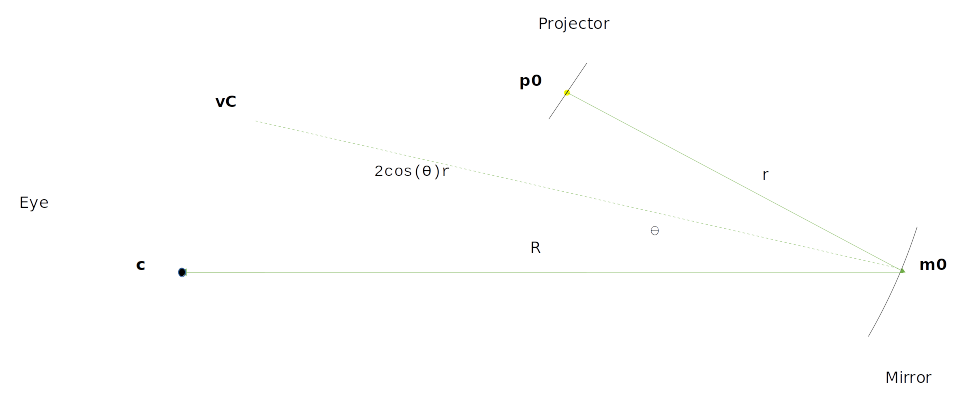

In [28]:
# use a step small enough to allow high order terms to be ignored
alias stepsPerRadian = 1000

# 350/1000 is about 22 degrees.  This will be below and above center, so 44 degrees total.
alias facetCount = 350

# the mirror and projector shapes will be built out from their edges in very small angular steps
phi = Float64(1.0) / stepsPerRadian
M_phiClockWise = Rotate2D(phi)
M_phiAntiClock = Rotate2D(-phi)

# now we are ready to take a step from current (projector, mirror) point pair to find
#  a near neighbor pair


![make m1.png](<attachment:make m1.png>)

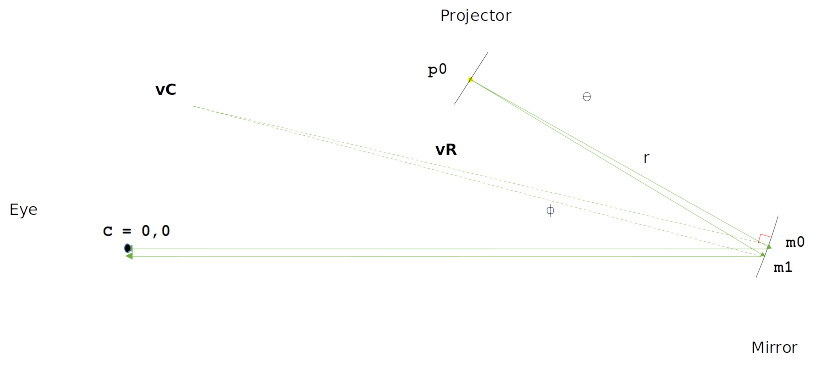

In [29]:
# the next projector pixel is found by working backwards using the new mirror position
# as defining the ray from the eye center and a new parallel goes to the prior mirror position

# create the next mirror position by rotating from the virtual center
var m1 = Mirror2D(vC - M_phiAntiClock.rot(vR), m0.tan - phi)

# Calculate the angular shift of the new mirror point from the eye.
# Eye center is origin(0,0) simplifying the math

var angle0 = math.atan(m0.p.y / m0.p.x)
var angle1 = math.atan(m1.p.y / m1.p.x)
var angleDif = angle0 - angle1
var RotDif = Rotate2D(angleDif)

# calculate the new reflections from mirror back to projector
var p_m1 = p0 - m1.p
var p1_a = m0.p + RotDif.rot(p_m)
var p1_b = m1.p + RotDif.rot(p_m1)

# derive a1 x + b1 y + c1 = 0 for line through p1_a and p_m
var a1 = (p1_a.y - p_m.y)
var b1 = (p_m.x - p1_a.x)
var c1 = -((a1 * p_m.x) + (b1 * p_m.y))
# verify zero
print((a1 * p1_a.x) + (b1 * p1_a.y) + c1)

# derive a2 x + b2 y + c2 = 0 for line through p1_b and p_m1
var a2 = (p1_b.y - p_m1.y)
var b2 = (p_m1.x - p1_b.x)
var c2 = -((a2 * p_m1.x) + (b2 * p_m1.y))
# verify zero
print((a2 * p1_b.x) + (b2 * p1_b.y) + c2)

var p1 = Point2D((b1*c2 - b2*c1) / (a1*b2 - a2*b1), (c1*a2 - c2*a1) / (a1*b2 - a2*b1))

print(angle1-angle0, p1.x, p1.y)


0.0
0.0
-0.0008536783112328036 38.789854660700477 21.195076633684486


![make p1.png](<attachment:make p1.png>)
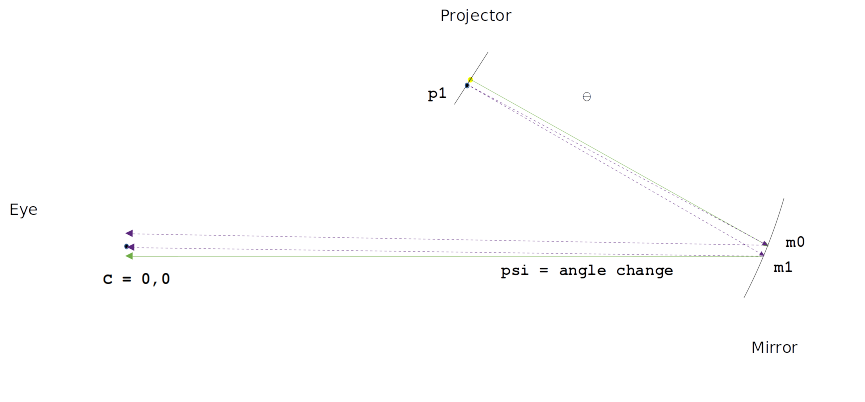

In [30]:
fn stepSurfaces (p0 : Point2D, m0 : Mirror2D, c : Point2D, phi : Float64, M_phi : Rotate2D, verify : Bool) -> PointMirrorPair :
    var p_m = p0 - m0.p
    var c_m = c - m0.p

    # lengths for convenience
    var r = p_m.length()
    var R = c_m.length()

    # theta is the half-angle between them - the angle from the normal at the mirror
    var theta = math.acos(p_m.dot(c_m) / (r*R)) / 2

    # a rotation for the mirror half angle
    var Mtheta = Rotate2D(theta) 

    # project the mirror normal back to a doubled radius point on parabola axis parallel to (c, m0)
    var vR = Mtheta.rot(p_m) * (2 * math.cos(theta))

    # the virtual center for the mirror is that axis point
    var vC = m0.p + vR

    # create the next mirror position by rotating from the virtual center
    var m1 = Mirror2D(vC - M_phi.rot(vR), m0.tan + phi)

    # the next projector pixel is found by working backwards using the new mirror position
    # as defining the ray from the eye center and a new parallel goes to the prior mirror position

    # we calculate the angular shift this requires.
    # Eye center is origin(0,0) simplifying the math

    var angle0 = math.atan(m0.p.y / m0.p.x)
    var angle1 = math.atan(m1.p.y / m1.p.x)
    var angleDif = angle0 - angle1
    var RotDif = Rotate2D(angleDif)

    # calculate the new reflections from mirror back to projector
    var p_m1 = p0 - m1.p
    var p1_a = m0.p + RotDif.rot(p_m)
    var p1_b = m1.p + RotDif.rot(p_m1)

    # derive a1 x + b1 y + c1 = 0 for line through p1_a and p_m
    var a1 = (p1_a.y - p_m.y)
    var b1 = (p_m.x - p1_a.x)
    var c1 = -((a1 * p_m.x) + (b1 * p_m.y))

    # derive a2 x + b2 y + c2 = 0 for line through p1_b and p_m1
    var a2 = (p1_b.y - p_m1.y)
    var b2 = (p_m1.x - p1_b.x)
    var c2 = -((a2 * p_m1.x) + (b2 * p_m1.y))

    var p1 = Point2D((b1*c2 - b2*c1) / (a1*b2 - a2*b1), (c1*a2 - c2*a1) / (a1*b2 - a2*b1))
    if verify :
        # verify zero
        print((a1 * p1.x) + (b1 * p1.y) + c1)
        print((a2 * p1.x) + (b2 * p1.y) + c2)

    return PointMirrorPair(p1, m1)


In [32]:
alias center = facetCount

var projs = Array[Point2D, (2 * facetCount) + 1]()
var mirs = Array[Mirror2D, (2 * facetCount) + 1]()
projs[center] = p0
mirs[center] = m0

# build the mirror by iterating angular steps sized phi relative to the projector
# start at the center
# first, build the steps down to index 0 of the arrays, the lower edge

for i in range(0, facetCount) :
    var verify = False # 0 == (i % 100)
    var newPairDown = stepSurfaces (projs[center - i], mirs[center - i], c, -phi, M_phiAntiClock, verify)
    projs[center - i - 1] = newPairDown.p
    mirs[center - i - 1] = newPairDown.m

    var newPairUp = stepSurfaces (projs[center + i], mirs[center + i], c, phi, M_phiClockWise, verify)
    projs[center + i + 1] = newPairUp.p
    mirs[center + i + 1] = newPairUp.m

lower = 0
upper = 2 * facetCount

# print (lower, projs[lower].x, projs[lower].y, mirs[lower].p.x, mirs[lower].p.y, mirs[lower].tan)
# print (center, projs[center].x, projs[center].y, mirs[center].p.x, mirs[center].p.y, mirs[center].tan)
# print (upper, projs[upper].x, projs[upper].y, mirs[upper].p.x, mirs[upper].p.y, mirs[upper].tan)

for i in range(0, (2 * facetCount) + 1, 50) :
    print (i, ", ", projs[i].x, ", ", projs[i].y, ", ", mirs[i].p.x, ", ", mirs[i].p.y, ", ", mirs[i].tan)


0 ,  38.298725288191704 ,  14.649952943730497 ,  48.999862979315175 ,  -16.469664506989069 ,  0.43539816339744797
50 ,  38.607439891372422 ,  15.611332470256265 ,  51.007364322743115 ,  -14.331888040856732 ,  0.48539816339744801
100 ,  38.820267211128431 ,  16.566378997942945 ,  52.870040209750705 ,  -12.112019374531144 ,  0.53539816339744806
150 ,  38.948514569765706 ,  17.513715383086279 ,  54.587583861492291 ,  -9.8164163759379335 ,  0.5853981633974481
200 ,  39.001780864101228 ,  18.452463987465375 ,  56.159679632069292 ,  -7.4512989354267241 ,  0.63539816339744815
250 ,  38.988191116158156 ,  19.382109219571326 ,  57.586000054302083 ,  -5.0227992984616954 ,  0.68539816339744819
300 ,  38.914604971178939 ,  20.302387502764788 ,  58.866213581469168 ,  -2.5370058643376083 ,  0.73539816339744823
350 ,  38.786799999999999 ,  21.213200000000001 ,  60.0 ,  0.0 ,  0.78539816339744828
400 ,  38.605563489223236 ,  22.113149651115087 ,  60.987380409034571 ,  2.5824221585220855 ,  0.835398163